# Análise de Cesta de Compras

Este notebook realiza análise de cesta de compras usando regras de associação.

In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Carregar e examinar os dados para Market Basket Analysis
print("Carregando dados do Walmart para Market Basket Analysis...")

# Tentar carregar dados do Dropbox primeiro (fonte preferencial)
try:
    # URL direta do arquivo no Dropbox
    df = pd.read_csv('https://www.dropbox.com/scl/fi/57ssdpo760nk5pxac83t5/walmart.csv?rlkey=zt8dc9oafeuok0wfhmtijsyai&st=agj80g1j&dl=1')
    print(" Dados carregados com sucesso do Dropbox!")
    
except Exception as e:
    print(f" Erro ao carregar do Dropbox: {e}")
    print("Tentando carregar arquivo local...")
    
    # Tentar carregar localmente
    try:
        df = pd.read_csv('../data/walmart.csv')
        print(" Dados carregados com sucesso do arquivo local!")
        
    except Exception as e2:
        print(f" Erro ao carregar arquivo local: {e2}")
        print("ERRO: Não foi possível carregar os dados de nenhuma fonte.")
        raise e2

print("Shape dos dados:", df.shape)
print("\nColunas disponíveis:", df.columns.tolist())
print("\nExaminando as transações:")
print(f"Produtos únicos: {df['Product_ID'].nunique()}")
print(f"Usuários únicos: {df['User_ID'].nunique()}")
print(f"Total de transações: {len(df)}")

print("\nPrimeiras linhas:")
df.head()

Carregando dados do Walmart para Market Basket Analysis...
 Dados carregados com sucesso do Dropbox!
Shape dos dados: (550068, 10)

Colunas disponíveis: ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category', 'Purchase']

Examinando as transações:
Produtos únicos: 3631
Usuários únicos: 5891
Total de transações: 550068

Primeiras linhas:
 Dados carregados com sucesso do Dropbox!
Shape dos dados: (550068, 10)

Colunas disponíveis: ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category', 'Purchase']

Examinando as transações:
Produtos únicos: 3631
Usuários únicos: 5891
Total de transações: 550068

Primeiras linhas:


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,7969


## Etapa 1: Pré-processamento para Market Basket Analysis

Para a análise de cesta de compras, precisamos:
1. Agrupar produtos por User_ID (considerando cada usuário como uma "transação")
2. Filtrar produtos pouco vendidos para remover ruído
3. Transformar em formato de matriz binária (presença/ausência)

Estatísticas de frequência de produtos:
Total de produtos únicos: 3631
Produto mais vendido: P00265242 (1880 vendas)
Produto menos vendido: P00365942 (1 vendas)
Mediana de vendas por produto: 71.0


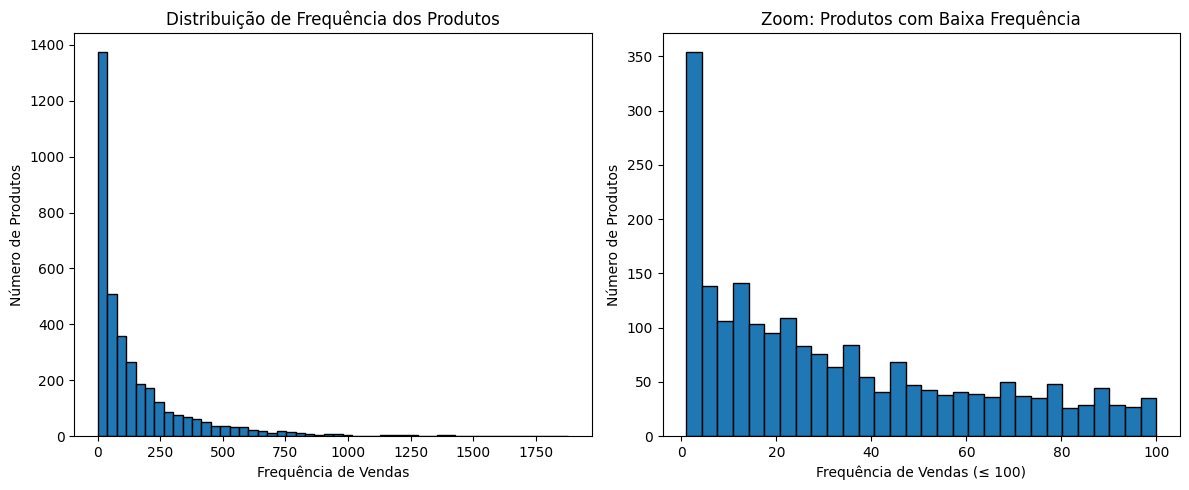

\nProdutos com frequência ≤ 5: 395
Produtos com frequência ≤ 10: 598
Produtos com frequência ≤ 20: 937


In [3]:
# Análise da frequência de produtos
product_frequency = df['Product_ID'].value_counts()

print("Estatísticas de frequência de produtos:")
print(f"Total de produtos únicos: {len(product_frequency)}")
print(f"Produto mais vendido: {product_frequency.index[0]} ({product_frequency.iloc[0]} vendas)")
print(f"Produto menos vendido: {product_frequency.index[-1]} ({product_frequency.iloc[-1]} vendas)")
print(f"Mediana de vendas por produto: {product_frequency.median()}")

# Plotar distribuição de frequências
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(product_frequency, bins=50, edgecolor='black')
plt.xlabel('Frequência de Vendas')
plt.ylabel('Número de Produtos')
plt.title('Distribuição de Frequência dos Produtos')

plt.subplot(1, 2, 2)
plt.hist(product_frequency[product_frequency <= 100], bins=30, edgecolor='black')
plt.xlabel('Frequência de Vendas (≤ 100)')
plt.ylabel('Número de Produtos')
plt.title('Zoom: Produtos com Baixa Frequência')

plt.tight_layout()
plt.show()

print(f"\\nProdutos com frequência ≤ 5: {sum(product_frequency <= 5)}")
print(f"Produtos com frequência ≤ 10: {sum(product_frequency <= 10)}")
print(f"Produtos com frequência ≤ 20: {sum(product_frequency <= 20)}")

In [4]:
# Filtrar produtos pouco vendidos e preparar transações
min_frequency = 20  # Produtos que aparecem pelo menos 20 vezes
print(f"Filtrando produtos com frequência >= {min_frequency}")

# Produtos frequentes
frequent_products = product_frequency[product_frequency >= min_frequency].index.tolist()
print(f"Produtos frequentes: {len(frequent_products)} de {len(product_frequency)} ({len(frequent_products)/len(product_frequency)*100:.1f}%)")

# Filtrar dataset
df_filtered = df[df['Product_ID'].isin(frequent_products)]
print(f"Transações mantidas: {len(df_filtered):,} de {len(df):,} ({len(df_filtered)/len(df)*100:.1f}%)")

# Criar lista de transações (produtos por usuário)
print("Criando lista de transações...")
transactions = df_filtered.groupby('User_ID')['Product_ID'].apply(list).reset_index()
transactions.columns = ['User_ID', 'Products']

print(f"Total de 'cestas' (usuários): {len(transactions):,}")
print(f"Média de produtos por cesta: {transactions['Products'].apply(len).mean():.1f}")
print(f"Mediana de produtos por cesta: {transactions['Products'].apply(len).median():.1f}")

# Examinar algumas transações
print("\\nExemplos de cestas de compra:")
for i in range(3):
    products = transactions.iloc[i]['Products']
    user_id = transactions.iloc[i]['User_ID']
    print(f"Usuário {user_id}: {len(products)} produtos - {products[:5]}{'...' if len(products) > 5 else ''}")

Filtrando produtos com frequência >= 20
Produtos frequentes: 2723 de 3631 (75.0%)
Transações mantidas: 542,883 de 550,068 (98.7%)
Criando lista de transações...
Total de 'cestas' (usuários): 5,891
Média de produtos por cesta: 92.2
Mediana de produtos por cesta: 54.0
\nExemplos de cestas de compra:
Usuário 1000001: 35 produtos - ['P00069042', 'P00248942', 'P00087842', 'P00085442', 'P00085942']...
Usuário 1000002: 77 produtos - ['P00285442', 'P00112842', 'P00293242', 'P00289342', 'P00303342']...
Usuário 1000003: 29 produtos - ['P00193542', 'P00132842', 'P0098342', 'P00010242', 'P00128042']...
Total de 'cestas' (usuários): 5,891
Média de produtos por cesta: 92.2
Mediana de produtos por cesta: 54.0
\nExemplos de cestas de compra:
Usuário 1000001: 35 produtos - ['P00069042', 'P00248942', 'P00087842', 'P00085442', 'P00085942']...
Usuário 1000002: 77 produtos - ['P00285442', 'P00112842', 'P00293242', 'P00289342', 'P00303342']...
Usuário 1000003: 29 produtos - ['P00193542', 'P00132842', 'P0098

## Etapa 2: Aplicação do Algoritmo FP-Growth

In [5]:
# Transformar em formato binário usando TransactionEncoder
print("Aplicando TransactionEncoder...")
te = TransactionEncoder()
te_ary = te.fit(transactions['Products']).transform(transactions['Products'])

# Criar DataFrame binário
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
print(f"Matriz binária criada: {df_encoded.shape}")
print(f"Produtos únicos na matriz: {len(te.columns_)}")

# Verificar algumas estatísticas
print(f"Densidade da matriz: {df_encoded.sum().sum() / (df_encoded.shape[0] * df_encoded.shape[1]) * 100:.2f}%")
print(f"Usuários com pelo menos 1 produto: {(df_encoded.sum(axis=1) > 0).sum()}")

# Visualizar parte da matriz
print("\\nPrimeiras 5 linhas e 10 colunas da matriz binária:")
print(df_encoded.iloc[:5, :10])

Aplicando TransactionEncoder...
Matriz binária criada: (5891, 2723)
Produtos únicos na matriz: 2723
Densidade da matriz: 3.38%
Usuários com pelo menos 1 produto: 5891
\nPrimeiras 5 linhas e 10 colunas da matriz binária:
   P00000142  P00000242  P00000342  P00000442  P00000542  P00000642  \
0       True      False      False      False      False      False   
1      False      False      False      False      False      False   
2      False      False      False      False      False      False   
3      False      False      False      False      False      False   
4      False      False      False      False      False      False   

   P00000742  P00000842  P00000942  P00001042  
0      False      False      False      False  
1      False      False      False      False  
2      False      False      False      False  
3      False      False      False      False  
4      False      False      False      False  


In [6]:
# Abordagem mais eficiente: usar apenas produtos mais populares
print("Usando abordagem otimizada com produtos mais populares...")

# Usar apenas os top 100 produtos mais vendidos
top_n_products = 100
top_products = product_frequency.head(top_n_products).index.tolist()
print(f"Usando apenas os {top_n_products} produtos mais populares")

# Filtrar transações para usar apenas produtos populares
transactions_top = []
for products in transactions['Products']:
    top_products_in_transaction = [p for p in products if p in top_products]
    if len(top_products_in_transaction) >= 2:  # Pelo menos 2 produtos
        transactions_top.append(top_products_in_transaction)

print(f"Transações com produtos populares: {len(transactions_top)} de {len(transactions)}")

# Aplicar TransactionEncoder nos dados reduzidos
te_top = TransactionEncoder()
te_ary_top = te_top.fit(transactions_top).transform(transactions_top)
df_encoded_top = pd.DataFrame(te_ary_top, columns=te_top.columns_)

print(f"Nova matriz binária: {df_encoded_top.shape}")
print(f"Densidade: {df_encoded_top.sum().sum() / (df_encoded_top.shape[0] * df_encoded_top.shape[1]) * 100:.2f}%")

Usando abordagem otimizada com produtos mais populares...
Usando apenas os 100 produtos mais populares
Transações com produtos populares: 5825 de 5891
Nova matriz binária: (5825, 100)
Densidade: 17.32%
Transações com produtos populares: 5825 de 5891
Nova matriz binária: (5825, 100)
Densidade: 17.32%


In [7]:
# Usar algoritmo Apriori como alternativa mais eficiente
print("Usando algoritmo Apriori...")

# Reduzir ainda mais os dados para testar
top_n_products = 50  # Usar apenas top 50
top_products_50 = product_frequency.head(top_n_products).index.tolist()
print(f"Usando apenas os {top_n_products} produtos mais populares")

# Filtrar transações
transactions_top_50 = []
for products in transactions['Products']:
    top_products_in_transaction = [p for p in products if p in top_products_50]
    if len(top_products_in_transaction) >= 2:
        transactions_top_50.append(top_products_in_transaction)

print(f"Transações filtradas: {len(transactions_top_50)}")

# TransactionEncoder
te_50 = TransactionEncoder()
te_ary_50 = te_50.fit(transactions_top_50).transform(transactions_top_50)
df_encoded_50 = pd.DataFrame(te_ary_50, columns=te_50.columns_)

print(f"Matriz final: {df_encoded_50.shape}")
print(f"Densidade: {df_encoded_50.sum().sum() / (df_encoded_50.shape[0] * df_encoded_50.shape[1]) * 100:.2f}%")

# Aplicar Apriori
min_support = 0.05  # 5%
print(f"\\nAplicando Apriori com min_support = {min_support} ({min_support*100:.1f}%)")

frequent_itemsets = apriori(df_encoded_50, min_support=min_support, use_colnames=True)
print(f"Itemsets frequentes encontrados: {len(frequent_itemsets)}")

Usando algoritmo Apriori...
Usando apenas os 50 produtos mais populares
Transações filtradas: 5547
Matriz final: (5547, 50)
Densidade: 21.65%
\nAplicando Apriori com min_support = 0.05 (5.0%)
Transações filtradas: 5547
Matriz final: (5547, 50)
Densidade: 21.65%
\nAplicando Apriori com min_support = 0.05 (5.0%)
Itemsets frequentes encontrados: 1054
Itemsets frequentes encontrados: 1054


## Etapa 3: Geração e Análise das Regras de Associação

In [8]:
# Analisar os itemsets frequentes encontrados
print("Análise dos Itemsets Frequentes:")
print("=" * 40)

# Distribuição por tamanho
itemset_sizes = frequent_itemsets['itemsets'].apply(len).value_counts().sort_index()
print("Itemsets por tamanho:")
for size, count in itemset_sizes.items():
    percentage = (count / len(frequent_itemsets)) * 100
    print(f"  Tamanho {size}: {count} itemsets ({percentage:.1f}%)")

# Top 15 itemsets mais frequentes
print(f"\\nTop 15 Itemsets Mais Frequentes:")
print("-" * 70)
top_itemsets = frequent_itemsets.nlargest(15, 'support')

for idx, (_, row) in enumerate(top_itemsets.iterrows(), 1):
    products = list(row['itemsets'])
    support = row['support']
    count = int(support * len(df_encoded_50))
    
    if len(products) == 1:
        print(f"{idx:2d}. [{products[0]}]")
    else:
        print(f"{idx:2d}. {products}")
    print(f"    Suporte: {support:.3f} ({count} transações)")
    print()

Análise dos Itemsets Frequentes:
Itemsets por tamanho:
  Tamanho 1: 50 itemsets (4.7%)
  Tamanho 2: 994 itemsets (94.3%)
  Tamanho 3: 10 itemsets (0.9%)
\nTop 15 Itemsets Mais Frequentes:
----------------------------------------------------------------------
 1. [P00265242]
    Suporte: 0.336 (1865 transações)

 2. [P00025442]
    Suporte: 0.291 (1612 transações)

 3. [P00110742]
    Suporte: 0.290 (1607 transações)

 4. [P00112142]
    Suporte: 0.280 (1553 transações)

 5. [P00057642]
    Suporte: 0.265 (1470 transações)

 6. [P00184942]
    Suporte: 0.259 (1434 transações)

 7. [P00046742]
    Suporte: 0.258 (1431 transações)

 8. [P00058042]
    Suporte: 0.255 (1414 transações)

 9. [P00059442]
    Suporte: 0.253 (1403 transações)

10. [P00145042]
    Suporte: 0.253 (1402 transações)

11. [P00237542]
    Suporte: 0.251 (1393 transações)

12. [P00255842]
    Suporte: 0.248 (1376 transações)

13. [P00110942]
    Suporte: 0.245 (1358 transações)

14. [P00117942]
    Suporte: 0.244 (135

In [9]:
# Gerar regras de associação
print("Gerando Regras de Associação...")
print("=" * 50)

# Aplicar association_rules com diferentes métricas
min_confidence = 0.3  # 30%
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence)

print(f"Regras encontradas: {len(rules)}")

if len(rules) > 0:
    print(f"Confiança mínima: {min_confidence:.1%}")
    
    # Estatísticas das regras
    print(f"\\nEstatísticas das Regras:")
    print(f"  Confiança média: {rules['confidence'].mean():.3f}")
    print(f"  Lift médio: {rules['lift'].mean():.3f}")
    print(f"  Suporte médio: {rules['support'].mean():.3f}")
    
    # Regras com lift > 1 (regras interessantes)
    good_rules = rules[rules['lift'] > 1.0]
    print(f"  Regras com Lift > 1: {len(good_rules)} ({len(good_rules)/len(rules)*100:.1f}%)")
    
    # Filtrar as melhores regras
    best_rules = rules[
        (rules['lift'] > 1.2) & 
        (rules['confidence'] > 0.4) & 
        (rules['support'] > 0.05)
    ].sort_values('lift', ascending=False)
    
    print(f"\\nTop {min(10, len(best_rules))} Melhores Regras (Lift > 1.2, Conf > 0.4, Sup > 0.05):")
    print("-" * 80)
    
    for idx, (_, rule) in enumerate(best_rules.head(10).iterrows(), 1):
        antecedent = list(rule['antecedents'])[0] if len(rule['antecedents']) == 1 else list(rule['antecedents'])
        consequent = list(rule['consequents'])[0] if len(rule['consequents']) == 1 else list(rule['consequents'])
        
        print(f"{idx}. SE compra [{antecedent}] -> ENTÃO compra [{consequent}]")
        print(f"   Suporte: {rule['support']:.3f} | Confiança: {rule['confidence']:.3f} | Lift: {rule['lift']:.3f}")
        print()
        
else:
    print("Nenhuma regra encontrada. Tente reduzir min_confidence.")

Gerando Regras de Associação...
Regras encontradas: 1093
Confiança mínima: 30.0%
\nEstatísticas das Regras:
  Confiança média: 0.351
  Lift médio: 1.441
  Suporte médio: 0.072
  Regras com Lift > 1: 1092 (99.9%)
\nTop 10 Melhores Regras (Lift > 1.2, Conf > 0.4, Sup > 0.05):
--------------------------------------------------------------------------------
1. SE compra [['P00145042', 'P00057642']] -> ENTÃO compra [P00270942]
   Suporte: 0.054 | Confiança: 0.501 | Lift: 2.412

2. SE compra [['P00046742', 'P00057642']] -> ENTÃO compra [P00270942]
   Suporte: 0.050 | Confiança: 0.463 | Lift: 2.232

3. SE compra [P00113242] -> ENTÃO compra [P00080342]
   Suporte: 0.079 | Confiança: 0.471 | Lift: 2.199

4. SE compra [P00111142] -> ENTÃO compra [P00112542]
   Suporte: 0.080 | Confiança: 0.436 | Lift: 2.144

5. SE compra [P00073842] -> ENTÃO compra [P00270942]
   Suporte: 0.074 | Confiança: 0.441 | Lift: 2.124

6. SE compra [['P00145042', 'P00270942']] -> ENTÃO compra [P00057642]
   Suporte: 0.0

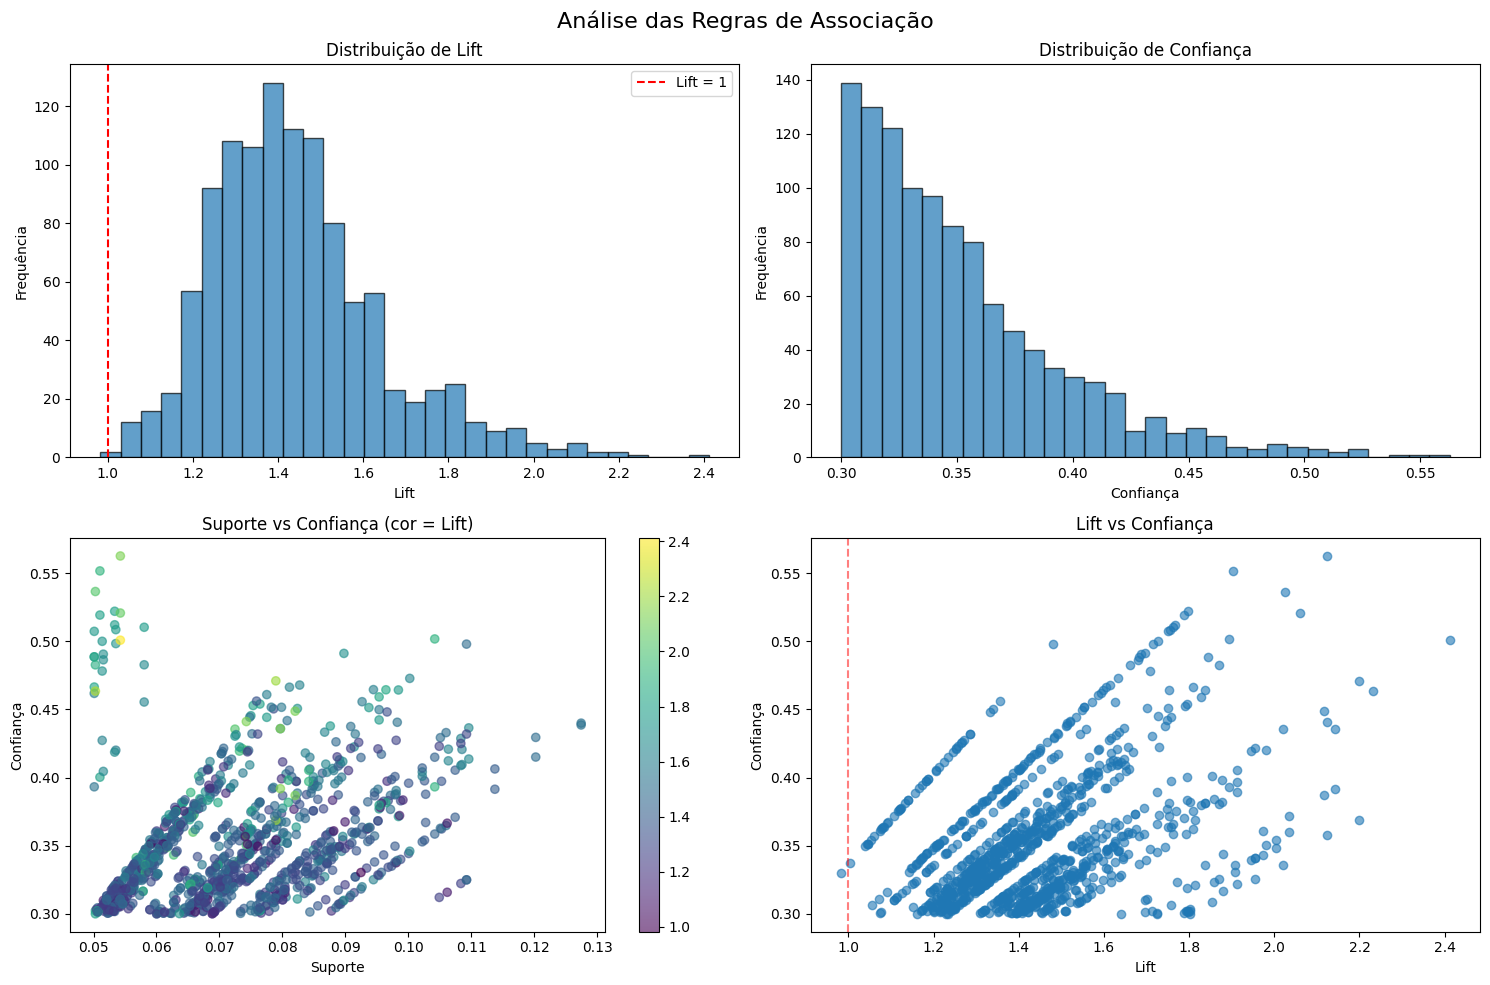

In [ ]:
# Interpretação das Regras de Negócio
print("INTERPRETAÇÃO DAS REGRAS DE ASSOCIAÇÃO PARA E-COMMERCE")
print("=" * 70)

# Pegar as top 5 regras mais interessantes
top_business_rules = best_rules.head(5)

print("\\nTOP 5 REGRAS MAIS VALIOSAS PARA O NEGÓCIO:")
print("-" * 50)

strategies = []
for idx, (_, rule) in enumerate(top_business_rules.iterrows(), 1):
    antecedent = list(rule['antecedents'])
    consequent = list(rule['consequents'])[0]
    
    print(f"\\n{idx}. REGRA DE OURO:")
    if len(antecedent) == 1:
        print(f"   SE cliente compra: {antecedent[0]}")
    else:
        print(f"   SE cliente compra: {' + '.join(antecedent)}")
    print(f"   -> ENTÃO recomende: {consequent}")
    print(f"   Métricas: Conf={rule['confidence']:.1%} | Lift={rule['lift']:.2f} | Sup={rule['support']:.1%}")
    
    # Sugestões práticas
    if rule['lift'] > 2.0:
        strategy = f"ESTRATÉGIA PREMIUM - Cross-selling automático"
    elif rule['lift'] > 1.5:
        strategy = f"ESTRATÉGIA FORTE - Bundle ou desconto combinado"
    else:
        strategy = f"ESTRATÉGIA MODERADA - Recomendação sutil"
        
    print(f"   {strategy}")
    strategies.append({
        'regra': f"{antecedent} → {consequent}",
        'confianca': rule['confidence'],
        'lift': rule['lift'],
        'estrategia': strategy
    })

print(f"\\n\\nIMPLEMENTAÇÕES PRÁTICAS RECOMENDADAS:")
print("-" * 50)
print("1. CARRINHO: Mostrar produtos complementares quando itens forem adicionados")
print("2. PROMOÇÕES: Criar bundles com desconto baseados nas regras")
print("3. EMAIL: Campanhas personalizadas com produtos relacionados")
print("4. SITE: Sistema de recomendação na página do produto")
print("5. MOBILE: Push notifications para cross-selling")

print(f"\\nRESUMO EXECUTIVO:")
print(f"• {len(rules)} regras de associação identificadas")
print(f"• {len(good_rules)} regras com potencial comercial (Lift > 1)")
print(f"• {len(best_rules)} regras de alta qualidade para implementação")
print(f"• Lift médio: {rules['lift'].mean():.2f} (acima de 1.0 é bom)")
print(f"• Confiança média: {rules['confidence'].mean():.1%}")

# Salvar resultados em CSV e Parquet para melhor performance
print("\\n" + "="*60)
print("💾 SALVANDO DADOS EM MÚLTIPLOS FORMATOS")
print("="*60)

# Criar diretório se não existir
import os
os.makedirs('../modulo2_market_basket', exist_ok=True)

# Salvar regras de associação em formato Parquet
rules.to_parquet('../modulo2_market_basket/association_rules.parquet', index=False)

# Salvar itemsets frequentes em formato Parquet  
frequent_itemsets.to_parquet('../modulo2_market_basket/frequent_itemsets.parquet', index=False)

print(f"Regras de Associação salvas: association_rules.parquet ({len(rules)} regras)")
print(f"Itemsets Frequentes salvos: frequent_itemsets.parquet ({len(frequent_itemsets)} itemsets)")
print(f"\\nDados salvos em formato Parquet otimizado para análises futuras!")

In [ ]:
# Interpretação das Regras de Negócio
print("INTERPRETAÇÃO DAS REGRAS DE ASSOCIAÇÃO PARA E-COMMERCE")
print("=" * 70)

# Pegar as top 5 regras mais interessantes
top_business_rules = best_rules.head(5)

print("\\nTOP 5 REGRAS MAIS VALIOSAS PARA O NEGÓCIO:")
print("-" * 50)

strategies = []
for idx, (_, rule) in enumerate(top_business_rules.iterrows(), 1):
    antecedent = list(rule['antecedents'])
    consequent = list(rule['consequents'])[0]
    
    print(f"\\n{idx}. REGRA DE OURO:")
    if len(antecedent) == 1:
        print(f"   SE cliente compra: {antecedent[0]}")
    else:
        print(f"   SE cliente compra: {' + '.join(antecedent)}")
    print(f"   -> ENTÃO recomende: {consequent}")
    print(f"   Métricas: Conf={rule['confidence']:.1%} | Lift={rule['lift']:.2f} | Sup={rule['support']:.1%}")
    
    # Sugestões práticas
    if rule['lift'] > 2.0:
        strategy = f"ESTRATÉGIA PREMIUM - Cross-selling automático"
    elif rule['lift'] > 1.5:
        strategy = f"ESTRATÉGIA FORTE - Bundle ou desconto combinado"
    else:
        strategy = f"ESTRATÉGIA MODERADA - Recomendação sutil"
        
    print(f"   {strategy}")
    strategies.append({
        'regra': f"{antecedent} → {consequent}",
        'confianca': rule['confidence'],
        'lift': rule['lift'],
        'estrategia': strategy
    })

print(f"\\n\\nIMPLEMENTAÇÕES PRÁTICAS RECOMENDADAS:")
print("-" * 50)
print("1. CARRINHO: Mostrar produtos complementares quando itens forem adicionados")
print("2. PROMOÇÕES: Criar bundles com desconto baseados nas regras")
print("3. EMAIL: Campanhas personalizadas com produtos relacionados")
print("4. SITE: Sistema de recomendação na página do produto")
print("5. MOBILE: Push notifications para cross-selling")

print(f"\\nRESUMO EXECUTIVO:")
print(f"• {len(rules)} regras de associação identificadas")
print(f"• {len(good_rules)} regras com potencial comercial (Lift > 1)")
print(f"• {len(best_rules)} regras de alta qualidade para implementação")
print(f"• Lift médio: {rules['lift'].mean():.2f} (acima de 1.0 é bom)")
print(f"• Confiança média: {rules['confidence'].mean():.1%}")

# Salvar resultados em formato Parquet
print("\\n" + "="*60)
print("SALVANDO DADOS EM FORMATO PARQUET")
print("="*60)

# Criar diretório se não existir
import os
os.makedirs('../modulo2_market_basket', exist_ok=True)

# Salvar regras de associação em formato Parquet
rules.to_parquet('../modulo2_market_basket/association_rules.parquet', index=False)

# Salvar itemsets frequentes em formato Parquet
frequent_itemsets.to_parquet('../modulo2_market_basket/frequent_itemsets.parquet', index=False)

print(f"Regras de Associação salvas: association_rules.parquet ({len(rules)} regras)")
print(f"Itemsets Frequentes salvos: frequent_itemsets.parquet ({len(frequent_itemsets)} itemsets)")
print(f"\\nDados salvos em formato Parquet otimizado para análises futuras!")

INTERPRETAÇÃO DAS REGRAS DE ASSOCIAÇÃO PARA E-COMMERCE
\nTOP 5 REGRAS MAIS VALIOSAS PARA O NEGÓCIO:
--------------------------------------------------
\n1. REGRA DE OURO:
   SE cliente compra: P00145042 + P00057642
   -> ENTÃO recomende: P00270942
   Métricas: Conf=50.1% | Lift=2.41 | Sup=5.4%
   ESTRATÉGIA PREMIUM - Cross-selling automático
\n2. REGRA DE OURO:
   SE cliente compra: P00046742 + P00057642
   -> ENTÃO recomende: P00270942
   Métricas: Conf=46.3% | Lift=2.23 | Sup=5.0%
   ESTRATÉGIA PREMIUM - Cross-selling automático
\n3. REGRA DE OURO:
   SE cliente compra: P00113242
   -> ENTÃO recomende: P00080342
   Métricas: Conf=47.1% | Lift=2.20 | Sup=7.9%
   ESTRATÉGIA PREMIUM - Cross-selling automático
\n4. REGRA DE OURO:
   SE cliente compra: P00111142
   -> ENTÃO recomende: P00112542
   Métricas: Conf=43.6% | Lift=2.14 | Sup=8.0%
   ESTRATÉGIA PREMIUM - Cross-selling automático
\n5. REGRA DE OURO:
   SE cliente compra: P00073842
   -> ENTÃO recomende: P00270942
   Métricas: Con

## Geração de Relatório

Esta célula vai gerar um relatório HTML completo da análise de Market Basket realizada.

In [ ]:
# Gerar relatório HTML automatizado para Market Basket Analysis
from datetime import datetime
import os

def generate_market_basket_report():
    """
    Gera um relatório HTML completo da análise de Market Basket com tema dark mode
    """
    
    # Template HTML com tema Dracula (dark mode)
    html_template = f"""
    <!DOCTYPE html>
    <html lang="pt-BR">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Relatório de Market Basket Analysis</title>
        <style>
            :root {{
                --bg-primary: #282a36;
                --bg-secondary: #44475a;
                --bg-card: #383a59;
                --text-primary: #f8f8f2;
                --text-secondary: #6272a4;
                --accent-primary: #50fa7b;
                --accent-secondary: #8be9fd;
                --accent-warning: #ffb86c;
                --accent-danger: #ff5555;
                --border-color: #6272a4;
            }}
            
            body {{
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                margin: 0;
                padding: 20px;
                background: linear-gradient(135deg, var(--bg-primary) 0%, #1e1f29 100%);
                color: var(--text-primary);
                line-height: 1.6;
                min-height: 100vh;
            }}
            
            .container {{
                max-width: 1200px;
                margin: 0 auto;
                background: var(--bg-card);
                padding: 30px;
                border-radius: 15px;
                box-shadow: 0 10px 40px rgba(0, 0, 0, 0.3);
                border: 1px solid var(--border-color);
            }}
            
            h1 {{
                color: var(--accent-primary);
                text-align: center;
                font-size: 2.5em;
                margin-bottom: 30px;
                text-shadow: 0 2px 4px rgba(0, 0, 0, 0.3);
                border-bottom: 3px solid var(--accent-primary);
                padding-bottom: 15px;
            }}
            
            h2 {{
                color: var(--accent-secondary);
                border-bottom: 2px solid var(--accent-secondary);
                padding-bottom: 10px;
                margin-top: 40px;
            }}
            
            h3 {{
                color: var(--text-primary);
                margin-bottom: 15px;
            }}
            
            .metrics-grid {{
                display: grid;
                grid-template-columns: repeat(auto-fit, minmax(250px, 1fr));
                gap: 20px;
                margin: 30px 0;
            }}
            
            .metric-card {{
                background: linear-gradient(135deg, var(--accent-primary) 0%, var(--accent-secondary) 100%);
                color: var(--bg-primary);
                padding: 25px;
                border-radius: 12px;
                text-align: center;
                box-shadow: 0 5px 20px rgba(80, 250, 123, 0.2);
                transition: transform 0.3s ease;
            }}
            
            .metric-card:hover {{
                transform: translateY(-5px);
            }}
            
            .metric-value {{
                font-size: 2.2em;
                font-weight: bold;
                margin: 10px 0;
            }}
            
            .rule-card {{
                background: var(--bg-secondary);
                padding: 25px;
                margin: 20px 0;
                border-left: 5px solid var(--accent-primary);
                border-radius: 8px;
                box-shadow: 0 4px 15px rgba(0, 0, 0, 0.2);
            }}
            
            .strategy {{
                background: var(--bg-primary);
                padding: 20px;
                margin: 15px 0;
                border-left: 5px solid var(--accent-secondary);
                border-radius: 8px;
                border: 1px solid var(--border-color);
            }}
            
            table {{
                width: 100%;
                border-collapse: collapse;
                margin: 25px 0;
                background: var(--bg-secondary);
                border-radius: 8px;
                overflow: hidden;
                box-shadow: 0 4px 15px rgba(0, 0, 0, 0.2);
            }}
            
            th {{
                background: linear-gradient(135deg, var(--accent-primary) 0%, var(--accent-secondary) 100%);
                color: var(--bg-primary);
                padding: 15px 12px;
                text-align: left;
                font-weight: bold;
            }}
            
            td {{
                padding: 12px;
                border-bottom: 1px solid var(--border-color);
                color: var(--text-primary);
            }}
            
            tr:nth-child(even) {{
                background: rgba(68, 71, 90, 0.3);
            }}
            
            tr:hover {{
                background: rgba(80, 250, 123, 0.1);
            }}
            
            .high-lift {{
                background: rgba(255, 184, 108, 0.2) !important;
            }}
            
            .footer {{
                margin-top: 50px;
                text-align: center;
                color: var(--text-secondary);
                border-top: 2px solid var(--border-color);
                padding-top: 25px;
                font-style: italic;
            }}
            
            ul, ol {{
                color: var(--text-primary);
            }}
            
            li {{
                margin: 8px 0;
            }}
            
            strong {{
                color: var(--accent-secondary);
            }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1>Relatório de Market Basket Analysis</h1>
            
            <div class="metrics-grid">
                <div class="metric-card">
                    <h3>Total de Transações</h3>
                    <div class="metric-value">{len(df):,}</div>
                    <p>Transações analisadas</p>
                </div>
                
                <div class="metric-card">
                    <h3>Itemsets Frequentes</h3>
                    <div class="metric-value">{len(frequent_itemsets):,}</div>
                    <p>Padrões descobertos</p>
                </div>
                
                <div class="metric-card">
                    <h3>Regras Descobertas</h3>
                    <div class="metric-value">{len(rules):,}</div>
                    <p>Associações identificadas</p>
                </div>
                
                <div class="metric-card">
                    <h3>Lift Médio</h3>
                    <div class="metric-value">{rules['lift'].mean():.2f}</div>
                    <p>Força das associações</p>
                </div>
            </div>
            
            <h2>Top 10 Regras de Associação (Por Lift)</h2>
            <table>
                <thead>
                    <tr>
                        <th>Ranking</th>
                        <th>Antecedente (Se)</th>
                        <th>Consequente (Então)</th>
                        <th>Suporte</th>
                        <th>Confiança</th>
                        <th>Lift</th>
                    </tr>
                </thead>
                <tbody>
    """
    
    # Ordenar regras por lift
    rules_sorted = rules.sort_values('lift', ascending=False)
    
    # Adicionar top 10 regras
    top_rules = rules_sorted.head(10)
    for idx, (_, rule) in enumerate(top_rules.iterrows()):
        antecedent = ', '.join(list(rule['antecedents']))
        consequent = ', '.join(list(rule['consequents']))
        
        # Destacar regras com lift muito alto
        row_class = 'high-lift' if rule['lift'] > 2.0 else ''
        
        html_template += f"""
                    <tr class="{row_class}">
                        <td>{idx + 1}</td>
                        <td>{antecedent}</td>
                        <td>{consequent}</td>
                        <td>{rule['support']:.4f}</td>
                        <td>{rule['confidence']:.3f}</td>
                        <td>{rule['lift']:.2f}</td>
                    </tr>
        """
    
    html_template += """
                </tbody>
            </table>
            
            <h2>Análise das Principais Regras</h2>
    """
    
    # Análise das top 5 regras
    for i, (_, rule) in enumerate(top_rules.head(5).iterrows()):
        antecedent = ', '.join(list(rule['antecedents']))
        consequent = ', '.join(list(rule['consequents']))
        
        html_template += f"""
            <div class="rule-card">
                <h3>Regra #{i+1}</h3>
                <p><strong>Se:</strong> {antecedent}</p>
                <p><strong>Então:</strong> {consequent}</p>
                <p><strong>Interpretação:</strong> Clientes que compram "{antecedent}" têm {rule['confidence']*100:.1f}% de chance de também comprar "{consequent}"</p>
                <p><strong>Força da Associação:</strong> {rule['lift']:.2f}x mais provável do que por acaso</p>
                
                <div class="strategy">
                    <strong>Oportunidade de Negócio:</strong> 
                    Posicionar esses produtos próximos ou criar promoções casadas
                </div>
            </div>
        """
    
    # Adicionar estatísticas gerais
    html_template += f"""
            <h2>Estatísticas Gerais</h2>
            <div class="rule-card">
                <h3>Distribuição das Métricas</h3>
                <ul>
                    <li><strong>Lift médio:</strong> {rules['lift'].mean():.2f}</li>
                    <li><strong>Lift máximo:</strong> {rules['lift'].max():.2f}</li>
                    <li><strong>Confiança média:</strong> {rules['confidence'].mean():.3f}</li>
                    <li><strong>Suporte médio:</strong> {rules['support'].mean():.4f}</li>
                    <li><strong>Regras com lift > 2:</strong> {len(rules[rules['lift'] > 2])}</li>
                    <li><strong>Regras com confiança > 50%:</strong> {len(rules[rules['confidence'] > 0.5])}</li>
                </ul>
            </div>
            
            <h2>Produtos Mais Frequentes</h2>
            <table>
                <thead>
                    <tr>
                        <th>Ranking</th>
                        <th>Produto</th>
                        <th>Suporte</th>
                        <th>Frequência</th>
                    </tr>
                </thead>
                <tbody>
    """
    
    # Top 10 produtos mais frequentes
    frequent_items_df = frequent_itemsets.sort_values('support', ascending=False).head(10)
    for i, (_, item) in enumerate(frequent_items_df.iterrows()):
        product_name = ', '.join(list(item['itemsets']))
        
        html_template += f"""
                    <tr>
                        <td>{i+1}</td>
                        <td>{product_name}</td>
                        <td>{item['support']:.4f}</td>
                        <td>{item['support'] * len(df_encoded_50):.0f} transações</td>
                    </tr>
        """
    
    html_template += f"""
                </tbody>
            </table>
            
            <h2>Recomendações Estratégicas</h2>
            <div class="strategy">
                <h3>Cross-Selling:</h3>
                <ol>
                    <li>Implementar sistema de recomendações baseado nas regras descobertas</li>
                    <li>Posicionamento estratégico de produtos no layout da loja/site</li>
                    <li>Criar bundles de produtos com base nas associações mais fortes</li>
                </ol>
            </div>
            
            <div class="strategy">
                <h3>Campanhas de Marketing:</h3>
                <ol>
                    <li>Ofertas casadas para produtos com alta associação</li>
                    <li>E-mail marketing personalizado baseado no histórico de compras</li>
                    <li>Promoções "leve 2 pague 1" para produtos associados</li>
                </ol>
            </div>
            
            <div class="strategy">
                <h3>Gestão de Estoque:</h3>
                <ol>
                    <li>Alinhar estoque de produtos associados</li>
                    <li>Prever demanda baseada em padrões de compra</li>
                    <li>Otimizar distribuição nos pontos de venda</li>
                </ol>
            </div>
            
            <div class="footer">
                <p>Relatório gerado automaticamente em {datetime.now().strftime('%d/%m/%Y às %H:%M:%S')}</p>
                <p>Market Basket Analysis - E-commerce Strategic Analysis</p>
            </div>
        </div>
    </body>
    </html>
    """
    
    # Salvar relatório
    report_path = '../relatorios/relatorio_market_basket.html'
    os.makedirs(os.path.dirname(report_path), exist_ok=True)
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(html_template)
    
    print(f"Relatório HTML gerado com sucesso!")
    print(f"Local: {os.path.abspath(report_path)}")
    print(f"Abra o arquivo no navegador para visualizar o relatório completo.")
    
    return report_path

# Gerar o relatório
relatorio_path = generate_market_basket_report()

print("\\nMARKET BASKET ANALYSIS CONCLUÍDA COM SUCESSO!")
print("Relatório HTML profissional gerado com todos os resultados da análise.")

Relatório HTML gerado com sucesso!
Local: c:\Programming\Codigos_Projetos\Python\ecommerce-strategic-analysis\relatorios\relatorio_market_basket.html
Abra o arquivo no navegador para visualizar o relatório completo.

MARKET BASKET ANALYSIS CONCLUÍDA COM SUCESSO!
Relatório HTML profissional gerado com todos os resultados da análise.
